## Overview
This notebook is used to generate various test vectors to support FALCON Digital Signal Processing unit tests. Vectors include: raw complex input data, filter coefficients, and raw complex output data.

## Constants
This notebook supports configurable behavior through environment variables, which in turn modify the notebook-level constants specified here.

In [14]:
from fractions import Fraction
import copy
import logging
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import os
from scipy import signal
import struct

In [15]:
INPUT_SAMPLE_RATE_STR = os.environ.get('INPUT_SAMPLE_RATE', '1000000')
CHANNEL_SAMPLE_RATES_STR = os.environ.get('CHANNEL_SAMPLE_RATES', '500000,250000')
FREQ_SHIFTS_STR = os.environ.get('FREQ_SHIFTS', '10000,-200000')
NUM_INPUT_SAMPLES_STR = os.environ.get('NUM_INPUT_SAMPLES', '1000000')
VERBOSE_LOGGING_STR = os.environ.get('VERBOSE', '0')
OUTPUT_FILE_BASE_NAME = os.environ.get('OUT_FILE_NAME', 'multi_rate_channelizer_test_vector')
SEED_STR = os.environ.get('SEED', '2020')

# convert from the string environment variables to other, more convenient, representations
INPUT_SAMPLE_RATE = np.array([INPUT_SAMPLE_RATE_STR], dtype=np.float64)
CHANNEL_SAMPLE_RATES = [int(x) for x in CHANNEL_SAMPLE_RATES_STR.split(',')]
FREQ_SHIFTS_IN_HZ = [int(x) for x in FREQ_SHIFTS_STR.split(',')]
NUM_INPUT_SAMPLES = int(NUM_INPUT_SAMPLES_STR)
RANDOM_SEED = int(SEED_STR)

INPUT_VEC_FILE_NAME = OUTPUT_FILE_BASE_NAME + "_x.bin"
OUTPUT_VEC_FILE_NAME = OUTPUT_FILE_BASE_NAME + "_y_shift_%d_hz.bin"
RESAMP_COEFF_FILE_NAME = OUTPUT_FILE_BASE_NAME + "_resamp_coeffs_%d_hz.txt"

VERBOSE_LOGGING = True
if VERBOSE_LOGGING_STR is not "1":
    VERBOSE_LOGGING = False

## Logging
Use the Python *logging* module for basic logging. Configure the logging level based on the provided command-line arguments.

In [16]:
logging_level = logging.INFO
if VERBOSE_LOGGING:
    logging_level = logging.DEBUG
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging_level)

In [17]:
logging.info("####################")
logging.info("# INPUT_SAMPLE_RATE       = %f" % (INPUT_SAMPLE_RATE))
logging.info("# CHANNEL_SAMPLE_RATES    = %s" % (str(CHANNEL_SAMPLE_RATES)))
logging.info("# FREQ_SHIFTS             = %s" % (str(FREQ_SHIFTS_IN_HZ)))
logging.info("# NUM_INPUT_SAMPLES       = %u" % (NUM_INPUT_SAMPLES))
logging.info("# INPUT_FILE_NAME         = %s" % (INPUT_VEC_FILE_NAME))
logging.info("# OUTPUT_FILE_NAME        = %s" % (OUTPUT_VEC_FILE_NAME))
logging.info("####################")

INFO:####################
INFO:# INPUT_SAMPLE_RATE       = 1000000.000000
INFO:# CHANNEL_SAMPLE_RATES    = [500000, 250000]
INFO:# FREQ_SHIFTS             = [10000, -200000]
INFO:# NUM_INPUT_SAMPLES       = 1000000
INFO:# INPUT_FILE_NAME         = multi_rate_channelizer_test_vector_x.bin
INFO:# OUTPUT_FILE_NAME        = multi_rate_channelizer_test_vector_y_shift_%d_hz.bin
INFO:####################


## Create a Complex Sinusoid

In [41]:
SIGNAL_SCALE = 2048
TONE_FREQS = []

# set the numpy random seed so that the output files are repeatable
np.random.seed(RANDOM_SEED)

t = np.arange(0, NUM_INPUT_SAMPLES, dtype=np.float64)
logging.info("Time (t) vector requires %.3f mega bytes" % (t.nbytes / 1024.0 / 1024.0))

# create a single tone at the center frequency
x = SIGNAL_SCALE * np.exp(1j * 2 * np.pi * t * float(INPUT_SAMPLE_RATE/INPUT_SAMPLE_RATE))

# add a series of tones
num_negative_tones = 10
num_positive_tones = 10

# add negative freq tones
for tone_idx in range(num_negative_tones):
    
    tone_freq = np.random.randint(-1 * (INPUT_SAMPLE_RATE / 2), 0)
    TONE_FREQS.append(tone_freq)
    
    temp_x = SIGNAL_SCALE * np.exp(1j * 2 * np.pi * t * float(tone_freq/INPUT_SAMPLE_RATE))
    temp_x = temp_x.astype(np.complex64)
    x += temp_x

# add positive freq tones
for tone_idx in range(num_positive_tones):
    
    tone_freq = np.random.randint(0, INPUT_SAMPLE_RATE / 2)
    TONE_FREQS.append(tone_freq)
    
    temp_x = SIGNAL_SCALE * np.exp(1j * 2 * np.pi * t * float(tone_freq/INPUT_SAMPLE_RATE))
    temp_x = temp_x.astype(np.complex64)
    x += temp_x

# add a small amount of noise
noise_power = 0.001 * INPUT_SAMPLE_RATE / 2
x += np.random.normal(scale=np.sqrt(noise_power), size=t.shape)

INFO:Time (t) vector requires 7.629 mega bytes


In [43]:
# preprocess the input and verify that all values fit within an int16_t range
for val_idx in range(len(x)):
    
    real_val = int(x[val_idx].real)
    imag_val = int(x[val_idx].imag)
    
    if abs(real_val) > 0x7FFF or abs(imag_val > 0x7FFF):
        x[val_idx] = (0 + 0j)
        logging.info("Updated value at index %u orig=(%f, %f)" % (val_idx, real_val, imag_val))

logging.info("Finished preprocessing...")

INFO:Updated value at index 0 orig=(43017.000000, 0.000000)
INFO:Finished preprocessing...


Plot the vector

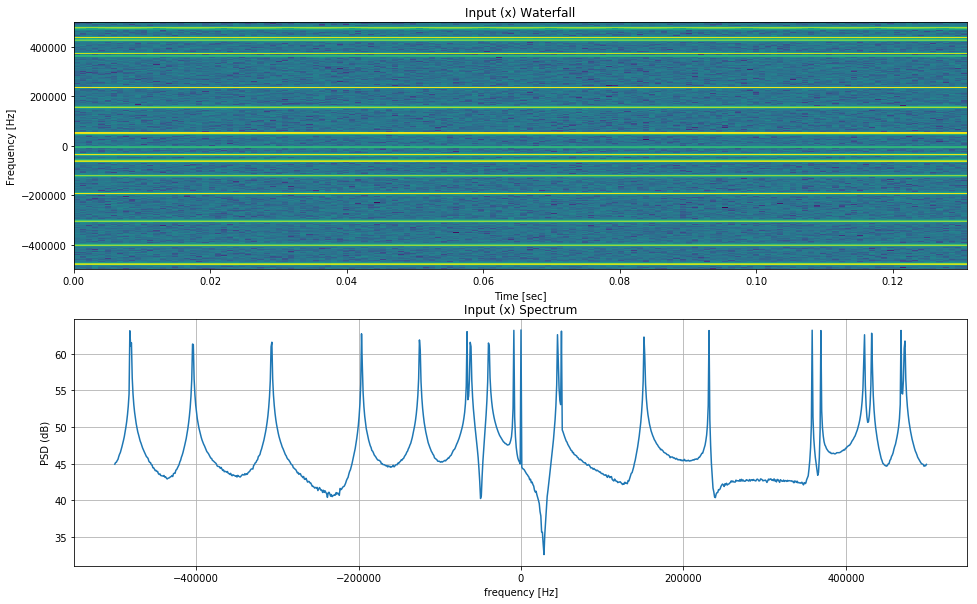

In [44]:
FFT_SIZE = 1024
NUM_FFTS = 128
plt.figure(figsize=(16, 10))

plt.subplot(2,1,1)
Pxx, freqs, bins, im = plt.specgram(x[:FFT_SIZE*NUM_FFTS], NFFT=FFT_SIZE, Fs=INPUT_SAMPLE_RATE)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Input (x) Waterfall')

plt.subplot(2,1,2)

psd = np.abs(np.fft.fftshift(np.fft.fft(x[:FFT_SIZE], FFT_SIZE)))
psd = 10 * np.log10(psd)
freqs = np.arange(-1 * (INPUT_SAMPLE_RATE / 2), (INPUT_SAMPLE_RATE / 2), INPUT_SAMPLE_RATE / FFT_SIZE, dtype=np.float64)
plt.plot(freqs, psd)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD (dB)')
plt.title('Input (x) Spectrum')
plt.grid(True)

In [ ]:
# save the input "x" vector file
input_vec_file = open(INPUT_VEC_FILE_NAME, 'wb')

num_samples_processed = 0
for val in x:
    
    real_val = int(val.real)
    imag_val = int(val.imag)
    
    # pack as little endian format using shorts (int16_t)
    input_vec_file.write(struct.pack('<2h', real_val, imag_val))
    
    num_samples_processed += 1
    
input_vec_file.close()

### Create Channelized Outputs and Save Output Vectors

INFO:Calculated float rollover index 100.0000000000000000
INFO:Adjusted float rollover index to 100000.0000000000000000
INFO:Computed max integer rollover index 100000
INFO:Resampling Ratio 0.500000
INFO:Resampling required; computed cutoff frequency: 0.25
INFO:Wrote filter coefficients to multi_rate_channelizer_test_vector_resamp_coeffs_10000_hz.txt
INFO:Wrote output data to multi_rate_channelizer_test_vector_y_shift_10000_hz.bin
INFO:Calculated float rollover index 5.0000000000000000
INFO:Adjusted float rollover index to 500000.0000000000000000
INFO:Computed max integer rollover index 500000
INFO:Resampling Ratio 0.250000
INFO:Resampling required; computed cutoff frequency: 0.12
INFO:Wrote filter coefficients to multi_rate_channelizer_test_vector_resamp_coeffs_-200000_hz.txt
INFO:Wrote output data to multi_rate_channelizer_test_vector_y_shift_-200000_hz.bin


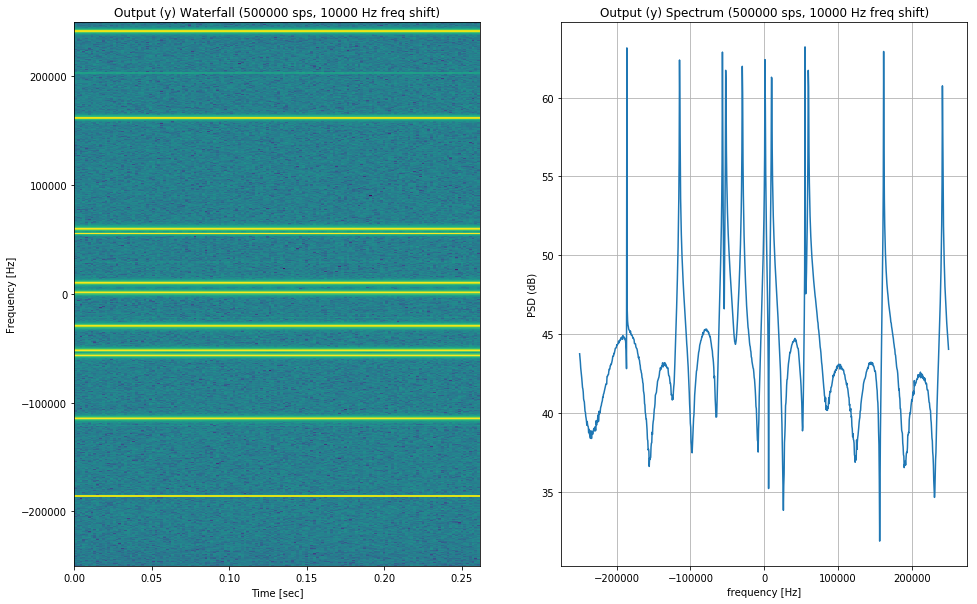

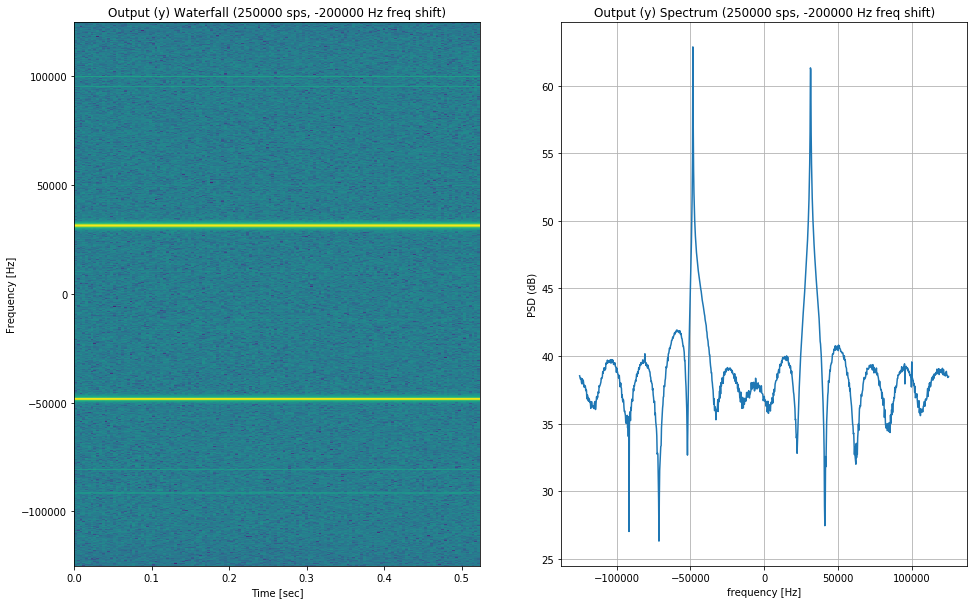

In [45]:
FFT_SIZE = 1024
NUM_FFTS = 128
plt.figure(figsize=(16, 10))

for file_idx in range(len(FREQ_SHIFTS_IN_HZ)):
    
    ########################################
    # Frequency shift the input
    #####
    
    freq_shift = FREQ_SHIFTS_IN_HZ[file_idx]
    shifted_y = copy.deepcopy(x)
    
    rollover_idx_float = INPUT_SAMPLE_RATE / abs(freq_shift)
    logging.info("Calculated float rollover index %.16f" % (rollover_idx_float))

    while rollover_idx_float < 1e5:
        rollover_idx_float = rollover_idx_float * 10.0

    logging.info("Adjusted float rollover index to %.16f" % (rollover_idx_float))
    
    rollover_idx = np.round(rollover_idx_float)
    logging.info("Computed max integer rollover index %u" % (rollover_idx))

    t = np.arange(0, len(shifted_y), dtype=np.float64)
    for ii in range(len(shifted_y)):
        t[ii] = ii % rollover_idx
    
    fs_vec = np.exp(1j * 2.0 * np.pi * t * (freq_shift/INPUT_SAMPLE_RATE))
    shifted_y = shifted_y * fs_vec
    
    
    ########################################
    # Now resample the vector
    #####
    
    resampling_ratio = CHANNEL_SAMPLE_RATES[file_idx] / INPUT_SAMPLE_RATE
    logging.info("Resampling Ratio %f" % (resampling_ratio))
    ratio = Fraction("%.12f" % (resampling_ratio)).limit_denominator()
    p = ratio.numerator
    q = ratio.denominator
    pqmax = max(p, q)
    
    # cutoff frequency of the lowpass filter at the high (upsampled) rate
    cutoff_freq = 1 / 2 / pqmax
    filter_order = 2 * 10 * pqmax + 1
    filter_delay = int((filter_order - 1) / p / 2)
        
    logging.info("Resampling required; computed cutoff frequency: %.2f" % (cutoff_freq))
    
    filter_coeffs = float(p) * signal.firls(filter_order, [0, 2.0 * cutoff_freq, 2.0 * cutoff_freq, 1.0], [1.0, 1.0, 0.0, 0.0])
    filter_coeffs = filter_coeffs * signal.kaiser(filter_order, beta=5)
    
    filter_coeffs_file_name = RESAMP_COEFF_FILE_NAME % freq_shift
    filter_coeffs_file = open(filter_coeffs_file_name, 'w')
    for coeff in filter_coeffs:
        filter_coeffs_file.write("%0.12f %0.12f\n" % (coeff.real, coeff.imag))
    
    filter_coeffs_file.close()

    logging.info("Wrote filter coefficients to %s" % (filter_coeffs_file_name))
    
    y = signal.upfirdn(filter_coeffs, shifted_y, p, q)
    
    # save the output "y" vector file
    output_vec_file = open(OUTPUT_VEC_FILE_NAME % (freq_shift), 'wb')

    num_samples_processed = 0
    for val in y:
    
        real_val = int(val.real)
        imag_val = int(val.imag)
    
        # pack as little endian format using shorts (int16_t)
        output_vec_file.write(struct.pack('<2h', real_val, imag_val))
    
        num_samples_processed += 1
    
    output_vec_file.close()
    
    logging.info("Wrote output data to %s" % (OUTPUT_VEC_FILE_NAME % (freq_shift)))

    # plot the resulting vector
    plt.figure(figsize=(16, 10))
    plt.subplot(1, 2, 1)
    Pxx, freqs, bins, im = plt.specgram(y[:FFT_SIZE*NUM_FFTS], NFFT=FFT_SIZE, Fs=CHANNEL_SAMPLE_RATES[file_idx])
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title('Output (y) Waterfall (%u sps, %d Hz freq shift)' % (CHANNEL_SAMPLE_RATES[file_idx], freq_shift))

    plt.subplot(1, 2, 2)

    psd = np.abs(np.fft.fftshift(np.fft.fft(y[:FFT_SIZE], FFT_SIZE)))
    psd = 10 * np.log10(psd)
    freqs = np.arange(-1 * (CHANNEL_SAMPLE_RATES[file_idx] / 2), (CHANNEL_SAMPLE_RATES[file_idx] / 2), CHANNEL_SAMPLE_RATES[file_idx] / FFT_SIZE, dtype=np.float64)
    plt.plot(freqs, psd)
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD (dB)')
    plt.title('Output (y) Spectrum (%u sps, %d Hz freq shift)' % (CHANNEL_SAMPLE_RATES[file_idx], freq_shift))
    plt.grid(True)
    